In [1]:
import numpy as np

from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

import time
import math
import os

from IPython.display import display

import matplotlib.pyplot as plt
%matplotlib inline

# functions to calculate WAMP, VWAP, etc. and display plots
from functions.market.features import *
from functions.preprocessing import *
from functions.evaluation import *

In [83]:
np.random.seed(1234)
# set_random_seed(1234)
np.set_printoptions(precision=2)

data_root_dir = "data/kraken/"
n_asset_pairs = 1
n_ss_per_file = 1440
lob_depth = 30
ss_shape = (2*lob_depth, 3)

In [84]:
updates_file_list, snapshots_file_list = read_file_list(data_root_dir=data_root_dir, verbose=True)

n_files = len(snapshots_file_list)
n_days = int(n_files / n_asset_pairs)

print(n_days, "days of data is collected.")

30 update files read.
30 snapshot files read.
30 days of data is collected.


# Dataprep

In [177]:
alpha = 5
delay = 50
n_labels = 3

if n_labels == 2:
    class_names = [-1, 1]
elif n_labels == 3:
    class_names = [-1, 0, 1]
else:
    class_names = []

In [178]:
dataset = np.zeros([n_files*n_ss_per_file], 
                   dtype=[('snapshot', np.float32, ss_shape), ('rel_prices', np.float32, 2*lob_depth), ('timestamp', np.float32, 1), ('wamp', np.float32, 1),('label', int, 1)])

global_cnt = 0

for i in range(n_asset_pairs):
    asset_pair_cnt = 0
    
    for j in range(n_days):
        data = np.loadtxt(snapshots_file_list[i*n_days+j], delimiter=',')
        
        for j, ss in enumerate(data):
            snapshot = ss[:-1].reshape(-1, 3)
            timestamp = ss[-1]
            wamp = calc_WAMP(ss)

            dataset[global_cnt]["snapshot"] = np.concatenate((
                snapshot[0:lob_depth], 
                snapshot[100:100+lob_depth]
            ))
            dataset[global_cnt]["rel_prices"] = [price / wamp for price in dataset[global_cnt]["snapshot"][:,0]]
            dataset[global_cnt]["timestamp"] = timestamp
            dataset[global_cnt]["wamp"] = wamp

            # calculate label for the last snapshot for which enough data is provided with this snapshot
            if asset_pair_cnt >= delay:
                mean = np.mean(dataset["wamp"][global_cnt-delay+1:global_cnt+1])
                act_wamp = dataset["wamp"][global_cnt-delay]
                
                spread = calc_spread(dataset["snapshot"][global_cnt-delay].flatten(), lob_depth)
                
                if n_labels == 2:
                    dataset[global_cnt-delay]["label"] = generate_binary_label(
                        wamp=act_wamp,
                        future_wamp_mean=mean,
                    )
                elif n_labels == 3:
                    dataset[global_cnt-delay]["label"] = generate_trinary_label(
                        wamp=act_wamp,
                        future_wamp_mean=mean,
                        spread=spread,
                        alpha=alpha
                    )
                else:
                    raise AttributeError()
                    
            asset_pair_cnt += 1
            global_cnt += 1
            
    # set back global_cnt to overwrite not labeled data (last delay number of elements)
    global_cnt = global_cnt-delay

dataset = dataset[:global_cnt]

In [166]:
len(dataset)

42817

In [167]:
count_labels(dataset)

UP labels: 21861 	 51.056823224420214%
NO_MOVE labels: 0 	 0.0%
DOWN labels: 20956 	 48.94317677557979%


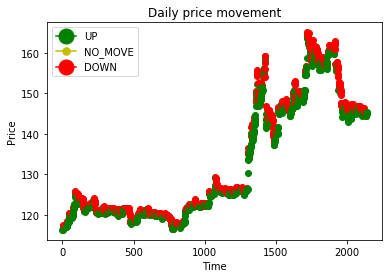

In [168]:
from functions.market.plots import plot_labels

plot_labels(dataset[::20]["wamp"], dataset[::20]["label"])

In [90]:
ups = dataset[np.where(dataset["label"] == 1)]
nomoves = dataset[np.where(dataset["label"] == 0)]
downs = dataset[np.where(dataset["label"] == -1)]

In [100]:
nb_samples = len(dataset)

n_samples_per_label = 10000

test_split = 0.2

In [101]:
# train-test-test split
train = np.concatenate(
    (ups[0:int(n_samples_per_label*(1-test_split))], 
     nomoves[0:int(n_samples_per_label*(1-test_split))], 
     downs[0:int(n_samples_per_label*(1-test_split))])
)

test = np.concatenate(
    (ups[int(n_samples_per_label*(1-test_split)):n_samples_per_label], 
     nomoves[int(n_samples_per_label*(1-test_split)):n_samples_per_label], 
     downs[int(n_samples_per_label*(1-test_split)):n_samples_per_label])
)

np.random.shuffle(train)
np.random.shuffle(test)

# input, select prices only
X_train = train['snapshot'][:,:,0:2]
X_test = test['snapshot'][:,:,0:2]

#X_train = train['rel_prices']
#X_test = test['rel_prices'] 

# reshape
X_train = X_train.reshape(-1, 2*lob_depth*2)
X_test = X_test.reshape(-1, 2*lob_depth*2)

# output
Y_train = train['label']
Y_test = test['label']

In [102]:
# number of labels in train set

count_labels(train)

UP labels: 8000 	 33.33333333333333%
NO_MOVE labels: 8000 	 33.33333333333333%
DOWN labels: 8000 	 33.33333333333333%


In [103]:
# number of labels in test set

count_labels(test)

UP labels: 2000 	 33.33333333333333%
NO_MOVE labels: 2000 	 33.33333333333333%
DOWN labels: 2000 	 33.33333333333333%


In [104]:
print(X_train.shape)
print(X_test.shape)

(24000, 120)
(6000, 120)


In [105]:
# standard scaling
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Linear Regression

In [ ]:
C = 1e-3

if n_labels == 2:
    logreg = linear_model.LogisticRegression(C=C,solver='lbfgs')
else:
    logreg = linear_model.LogisticRegression(C=C,solver='saga', multi_class='multinomial', max_iter=10000, n_jobs=-1)

logreg.fit(X_train,Y_train)

In [ ]:
logreg.score(X_test,Y_test)

In [ ]:
predictions = logreg.predict(X_test)

In [ ]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(Y_test, predictions, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(Y_test, predictions, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

# Random Forest

In [106]:
#Create a Gaussian Classifier
clf = RandomForestClassifier(n_estimators = 128, random_state = 42)

clf.fit(X_train,Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=128, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [107]:
predictions=clf.predict(X_test)

print("R^2 score:", clf.score(X_test, Y_test))

R^2 score: 0.4405


Confusion matrix, without normalization


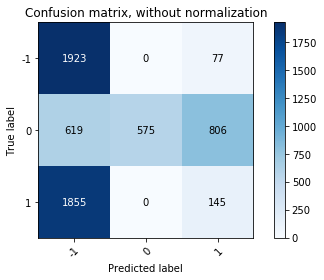

Normalized confusion matrix


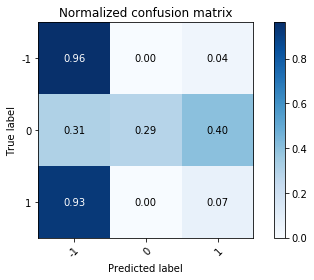

In [108]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(Y_test, predictions, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(Y_test, predictions, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

# Predict based on history

In [179]:
history_len = 100
alpha = 0.01

predictions = np.zeros([len(dataset)-history_len], dtype=[("label", int, 1)])

# make predictions
for i in range(len(dataset)-history_len):
    mean = np.mean(dataset["wamp"][i:i+history_len])
    act_wamp = dataset["wamp"][i+history_len]
    spread = calc_spread(dataset[i+history_len]["snapshot"].flatten(), lob_depth)
    
    threshold = act_wamp * alpha
    
    if n_labels == 2:
        if mean < wamp:
            predictions[i] = 1
        else:
            predictions[i] = -1
    
    elif n_labels == 3:
        if mean - wamp < -(threshold):
            predictions[i] = 1
        elif mean - wamp > threshold:
            predictions[i] = -1
        else:
            predictions[i] = 0
    else:
        raise AttributeError()

In [180]:
count_labels(dataset[history_len:])

UP labels: 11621 	 27.204625793009807%
NO_MOVE labels: 20402 	 47.76084462860219%
DOWN labels: 10694 	 25.034529578387993%


In [181]:
count_labels(predictions)

UP labels: 28386 	 66.45129573706019%
NO_MOVE labels: 5688 	 13.315541821757146%
DOWN labels: 8643 	 20.233162441182667%


Confusion matrix, without normalization


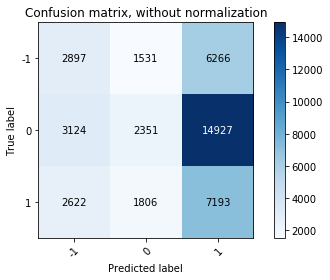

Normalized confusion matrix


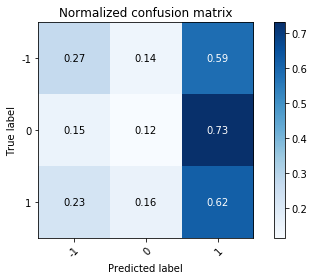

In [182]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(dataset["label"][history_len:], predictions["label"], classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(dataset["label"][history_len:], predictions["label"], classes=class_names, normalize=True,
                      title='Normalized confusion matrix')